In [27]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.5) 
sns.set_style("white")

# Pretty display for notebooks
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as grd
import matplotlib.ticker as tkr
import matplotlib.font_manager as font_manager

from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams

#define plotter
minorLocatorx   = AutoMinorLocator(10)
minorLocatory   = AutoMinorLocator(4)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.linewidth'] = 4
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman') 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
 

In [2]:
# Load the Ames housing dataset. This will have to be split for evaluation!
data = pd.read_csv('train.csv')
data = data.drop(['Id'], axis=1)
# If submitting to Kaggle, load the data required to test predictions.
#data_test = pd.read_csv('test.csv')

# Success
print "Ames housing dataset has {} data points with {} variables each.".format(*data.shape)
print data.tail(3)

Ames housing dataset has 1460 data points with 80 variables each.
      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1457          70       RL         66.0     9042   Pave   NaN      Reg   
1458          20       RL         68.0     9717   Pave   NaN      Reg   
1459          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig    ...     PoolArea PoolQC  Fence  \
1457         Lvl    AllPub    Inside    ...            0    NaN  GdPrv   
1458         Lvl    AllPub    Inside    ...            0    NaN    NaN   
1459         Lvl    AllPub    Inside    ...            0    NaN    NaN   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
1457        Shed    2500      5    2010        WD         Normal     266500  
1458         NaN       0      4    2010        WD         Normal     142125  
1459         NaN       0      6    2008        WD         Normal     147500  

[3 rows x 80 columns]


In [3]:
# Define functions for creating sets and training.
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

############################################## Create Train/Test Splits ##############################################
############################################## Create Train/Test Splits ##############################################

def create_sets(X, y):
    # Split into training and testing components first
    from sklearn.cross_validation import train_test_split, ShuffleSplit
    
    # Set the number of training points
    num_train = int(round(0.80*len(X)))
    
    # Set the number of testing points
    num_test = X.shape[0] - num_train
    
    # Shuffle and split the dataset into the number of training and testing points above
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = num_train, random_state=123458)
    
    # Show the results of the split
    print "Training set has {} samples.".format(X_train.shape[0])
    print "Testing set has {} samples.".format(X_test.shape[0])
    return X_train, X_test, y_train, y_test

##############################################   Model   Fitting   ##############################################
##############################################   Model   Fitting   ##############################################

# Using GridSearch CV, we fine tune the model.

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.grid_search import GridSearchCV


def fit_model(X, y, n_estimators = 1000, min_samples_leaf = 1, min_samples_split =2):
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20)
    regressor = GradientBoostingRegressor(n_estimators=n_estimators,min_samples_leaf = 1, 
                                          min_samples_split =2,random_state=102345)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'learning_rate': [0.01, 0.02, 0.05, 0.1], # 'n_estimators': [100, 500, 1000],
              'max_depth': [2, 3, 4, 6], 'min_samples_leaf':  [2,3,5,9,17]}
    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)
    # Create the grid search object
    grid = GridSearchCV(regressor, params, cv=cv_sets, scoring = scoring_fnc)#, verbose=10)
    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X_train, y_train)
    # Print the optimal model after fitting the data
    print 'The cross-validation scores = {:.2f}'.format(grid.best_score_)
    print grid.best_estimator_
    return grid

In [4]:
#Make dummies for categorical features.
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'GarageCond' => 'GarageCond_Ex', etc.
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

In [5]:
nan_data = data[pd.isnull(data).any(axis=1)]
for col in nan_data.columns:
    tmp = nan_data[col][pd.isnull(nan_data[col])]
    if len(tmp) >= 1:
        #print "These features have NULLs to signify the absence of such a feature:"
        print col, len(tmp)
        data[col] = data[col].fillna(0.)
print np.shape(data)
y_all =  data['SalePrice'] #in the log
X_all =  data[data.columns[:-1]]

LotFrontage 259
Alley 1369
MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406
(1460, 80)


In [6]:
X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(sorted(X_all.columns)))
print np.shape(X_all)

Processed feature columns (304 total features):
['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley_0.0', 'Alley_Grvl', 'Alley_Pave', 'BedroomAbvGr', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'BsmtCond_0.0', 'BsmtCond_Fa', 'BsmtCond_Gd', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_0.0', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1_0.0', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_0.0', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual_0.0', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtUnfSF', 'CentralAir_N', 'CentralAir_Y', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRA

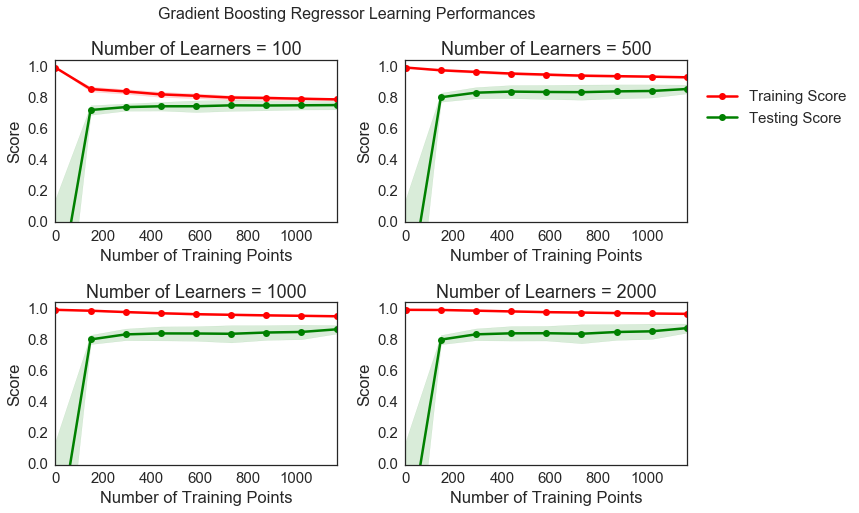

In [7]:
import visuals as vs
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("white")
vs.ModelLearning(X_all, y_all)


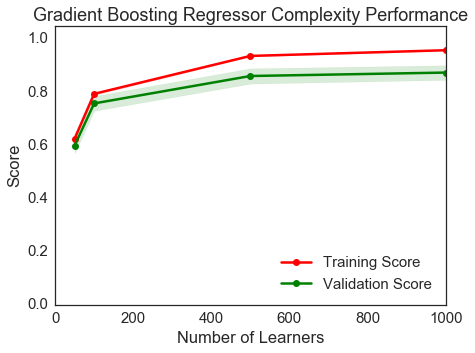

In [8]:
vs.ModelComplexity(X_all, y_all)

In [10]:
X_train, X_test, y_train, y_test = create_sets(X_all, y_all)
reg = fit_model(X_train, y_train, n_estimators=1000, min_samples_leaf = 1, min_samples_split = 10)
pred = reg.predict(X_test)
    
print 'The R$^2$ = {:.2f}'.format(r2_score(pred, y_test))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred, y_test))

Training set has 1168 samples.
Testing set has 292 samples.
The cross-validation scores = 0.91
GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.02, loss='ls',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=3, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=102345, subsample=1.0, verbose=0,
             warm_start=False)
The R$^2$ = 0.90
The  RMSE = 5.23e+08.


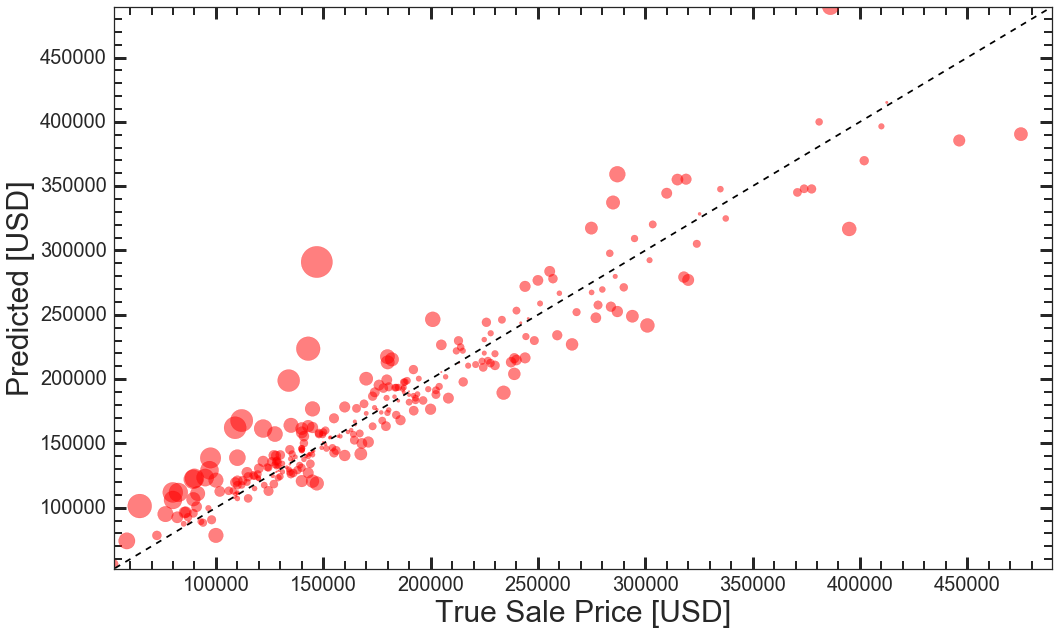

In [30]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
plt.scatter(y_test, pred, alpha = 0.5, s = 1000*np.abs(y_test-pred)/y_test, color = 'red')
plt.xlabel("True Sale Price [USD]", fontsize = 30);
plt.ylabel(r"Predicted [USD]", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.plot(np.arange(0,1000000, 100000), np.arange(0,1000000, 100000), 'k--')
plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.xlim(min([min(y_test), min(pred)]), max([max(y_test), max(pred)]))
plt.ylim(min([min(y_test), min(pred)]), max([max(y_test), max(pred)]))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("FinalModel_linear_all.pdf")

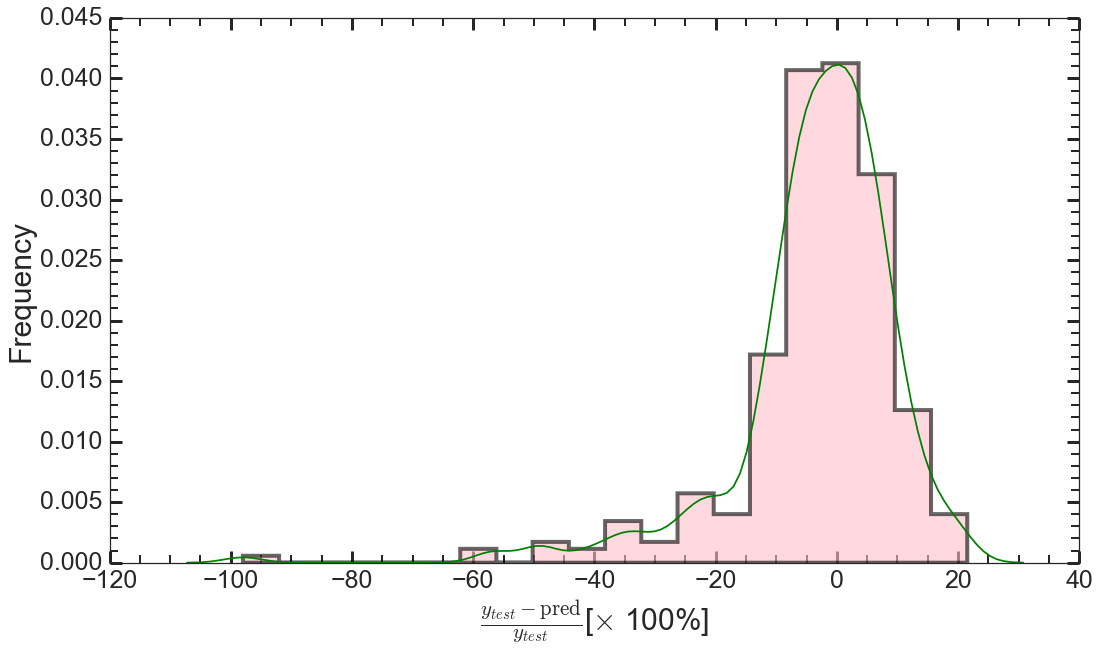

In [31]:

diff = (y_test - pred)/y_test*100.
sns.distplot(diff, bins=20, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
                                                    "alpha": 0.60, "color": "pink"});
plt.xlabel(r"$\frac{y_{test} - \mathrm{pred} }{y_{test}}$" + r"[$ \times $ 100%]", fontsize = 30);
plt.ylabel(r"Frequency", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.savefig('FinalDiffDist_linear_all.pdf')

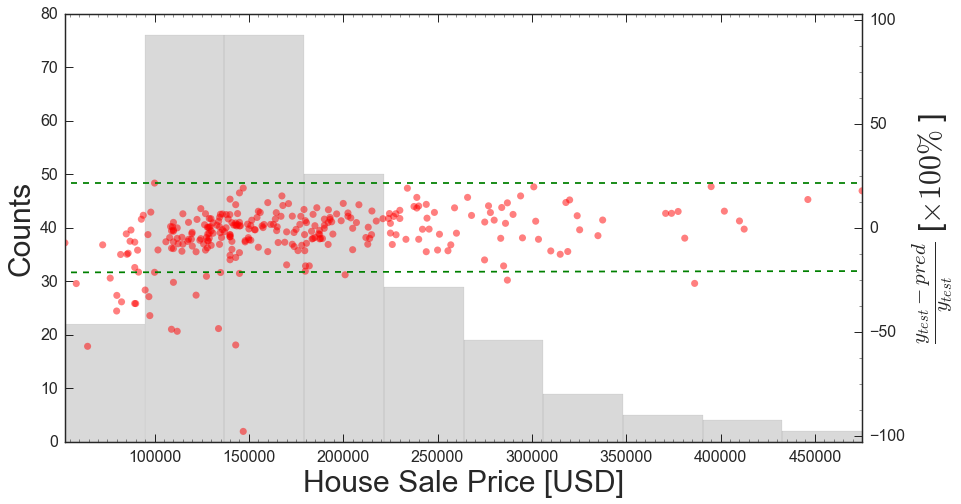

In [33]:
#SECONDARY AXIS WITH COLOR BAR

from scipy import stats

fig = plt.figure()#, figsize=(6,6))
gs = grd.GridSpec(2, 1, height_ratios=[1,15], width_ratios=[20,1], wspace=0.1)

#Primary plot
ax1 = plt.subplot(gs[1])
ax1.hist(y_test, color = ["black"], alpha=0.15)

plt.xlabel(r'House Sale Price [USD]', size=30)
plt.ylabel('Counts', size = 30)


#Secondary AXIS
ax2 = ax1.twinx()
ax2.xaxis.set_minor_locator(minorLocatorx)
ax2.yaxis.set_minor_locator(minorLocatory)

ax2.scatter(y_test, diff,  edgecolor= 'none', s=50, c='red', alpha=0.5)
ax2.set_ylabel(r"$\frac{y_{test} - pred }{y_{test}}$" + r" [$\times 100\% $ ]", fontsize = 30);

plt.plot([0, 1e8], [2*np.std(np.abs(diff)),2*np.std(np.abs(diff))], color = 'green', linestyle = '--')
plt.plot([0, 1e8], [-2*np.std(np.abs(diff)),12*np.std(np.abs(diff))], color = 'green', linestyle = '--')
plt.ylim(min(diff)-5, max(np.abs(diff))+5)
plt.xlim(min(y_test), max(y_test));
plt.savefig('Residuals_linear_all.pdf')

In [14]:
np.sqrt(np.sum((np.log(y_test +1) - np.log(pred+1))**2)/len(y_test))

0.12262651241384935

In [39]:
## Start from a clean slate
## Load the Ames housing dataset. This will have to be split for evaluation!
data = pd.read_csv('train.csv')
data = data.drop(['Id'], axis=1)
## ake care of NaNs
nan_data = data[pd.isnull(data).any(axis=1)]
for col in nan_data.columns:
    tmp = nan_data[col][pd.isnull(nan_data[col])]
    if len(tmp) >= 1:
        #print "These features have NULLs to signify the absence of such a feature:"
        print col, len(tmp)
        data[col] = data[col].fillna(0.)

y_all =  data['SalePrice'] #in the log
X_all =  preprocess_features(data[data.columns[:-1]])
print np.shape(X_all)


LotFrontage 259
Alley 1369
MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406
(1460, 304)


In [ ]:
y_all_log = np.log10(y_all)
X_train_log, X_test_log, y_train_log, y_test_log = create_sets(X_all, y_all_log)
reg_log = fit_model(X_train_log, y_train_log, n_estimators=1000, min_samples_leaf = 1, min_samples_split = 10)
pred_log = reg_log.predict(X_test_log)
    


Training set has 1168 samples.
Testing set has 292 samples.


In [ ]:
pred_log = reg_log.predict(X_test_log)
print 'The R$^2$ = {:.2f}'.format(r2_score(pred_log, 10**y_test_log))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred_log, 10**y_test_log))

In [ ]:
X_test_log

In [ ]:
y_test_log

In [ ]:
data['SalePrice']

In [ ]:
reg_log